In [2]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

from pydantic import BaseModel, Field, ValidationError
from typing import Annotated, Literal
import json
import re

class CustomBaseModel(BaseModel):
    @classmethod
    def get_json_schema(cls) -> str: 
        return json.dumps(cls.model_json_schema()["properties"])

class Goal(CustomBaseModel):
    name: str = Field("Name of the goal that user is trying to achieve")
    amount: float = Field("Amount that user is trying to save for the given goal")

class UserProfile(CustomBaseModel):
    income: float = Field(description="monthly income")
    expenses: float = Field(description="monthly expenses")
    tolerance: Literal["low", "medium", "high"] = Field(description="Risk tolerance")
    preferences: list[str] = Field(default=[], description="A list of user's preferences where they'd like to invest.")
    goals: list[Goal] = Field(default=[], description="A list of goals that user is trying to achieve by investing")
    

In [4]:
def extract_content_from_tags(tag_name, txt: str):
    match = re.search(f"<{tag_name}>(.*?)</{tag_name}>", txt, re.DOTALL)
    return match[1] if match else None

In [44]:
class SharedState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages] = Field(default=[])
    user_profile: UserProfile = Field(default=None, description="contains information regarding User's income/expenses/their risk tolerance etc.")
    question_to_ask: str | None = Field(default=None)
    user_response: str | None = Field(default=None)
    risk_report: str = Field(default=None)

In [40]:
def collect_user_profile(state: SharedState):
    prompt_template = """
    You are a financial assistant. Your task is to extract a user's financial profile from their message, strictlyt following the provided JSON schema.

    Instructions:
    1. Use the JSON schema provided in <schema></schema> as an example to determine which fields to extract, their types, and any default values.
    2. If a field is missing in the user's input but has a default in the schema use that default.
        - If the field is mandatory and missing, Generate a short descriptive question and (if mthere are multiple questions to ask, unify and ask as single) and enclose it within <question_to_ask></question_to_ask>

    3. only include fields defined in the schema.
    4. output valid JSON
    5. Do not add any extra fields
    6. Do not make any assumptions. Strictly follow the guidelines

    <schema>
    %s
    </schema>

    This is the input example:
    "I earn 5000$ per month and I spend 3000$. I want to save 2000$ for a vacation."

    Example of expected JSON output(wrap the JSON within <generated_json></generated_json> tags):
    {
        "income": 5000,
        "expenses": 3000,
        "tolerance": "medium",
        "preferences": [],
        "goals: [{"name": "vacation", "amount": 2000}]
    }
    """
    system_message = SystemMessage(prompt_template % UserProfile.get_json_schema())
    
    try:
        llm_response = llm.invoke([system_message] + state.messages)
        extracted_content = extract_content_from_tags("question_to_ask", llm_response.content)
        if extracted_content is not None:
            state.messages = [] + [llm_response]
            state.question_to_ask = extracted_content
            return state

        extracted_content = extract_content_from_tags("generated_json", llm_response.content)
        extracted_json = json.loads(extracted_content)
        user_profile = UserProfile(**extracted_json)
        
    except ValidationError as e:
        print("validation error!")
        user_profile = None
        
    state.question_to_ask = None
    state.user_response = None
    state.messages = [llm_response]
    state.user_profile = user_profile
    return state

def should_ask_to_clarify(state: SharedState) -> Literal["ask_user_to_clarify", "risk_check_agent"]:
    user_profile = state.user_profile
    
    if user_profile is None or user_profile.income == 0 or user_profile.expenses == 0:
        return "ask_user_to_clarify"
    
    return "risk_check_agent"
    
def ask_user_to_clarify(state: SharedState) -> Command[Literal["collect_user_profile"]]:
    user_response = interrupt(f"\n {state.question_to_ask}")
    return Command(goto="collect_user_profile", update={"messages": [AIMessage(state.question_to_ask), HumanMessage(user_response)]})
      
def risk_check_agent(state: SharedState):
    system_prompt = SystemMessage("""You are a financial risk assessment assistant.
    Your task is to review a user's financial profile and explain potential risks and feasability of their financial situation.

    You will be provided with:
    1. The user's profile (income,  expenses, risk tolerance, goals, preferences).

    Instructions:
    - Carefully read the profile
    - Provide a concise but clear "Risk report" in plain English.
    - Explicitly explain why each risk flag matters in user-friendly terms
    - If the user's risk tolerance is misaligned with their financial reality highlight it
    - If goals are unrealistic suggest adjustments. (e.g. smaller goals, longer timeframe)
    - Maintain a supportive and professional tone
    - Do not invent numbers. Rely only on provided profile and calculations
    - Keep your output in under 150-200 words.
    """)

    profile = state.user_profile
    risk_flags = []
    disposable_income = profile.income - profile.expenses

    if disposable_income < 0:
        risk_flags.append("Negative cash flow")
    elif disposable_income < profile.income * 0.1:
        risk_flags.append("Low disposable income (<10% of income)")

    if profile.tolerance == "high" and disposable_income < profile.income * 0.1:
        risk_flags.append("High risk tolerance misaligned with limited finances")

    for goal in profile.goals:
        if goal.amount > disposable_income * 12:
            risk_flags.append(f"Goal '{goal.name}' may be unrealistic with current savings")

    llm_input = {
        "profile": profile.dict(),
        "calculations": {
            "disposable_income": disposable_income,
            "risk_flags": risk_flags
        }
    }

    res = llm.invoke([system_prompt, HumanMessage(json.dumps(llm_input))])

    state.messages = [res]
    state.risk_report = res.contenmt
    return state

    

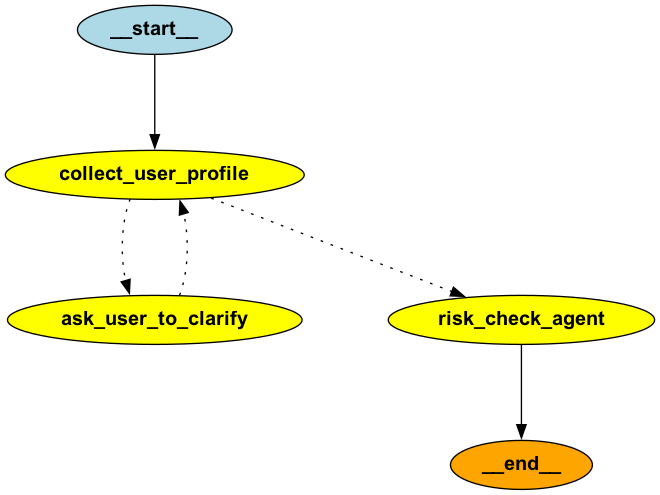

In [41]:
builder = StateGraph(SharedState)
builder.add_node(collect_user_profile)
builder.add_node(ask_user_to_clarify)
builder.add_node(risk_check_agent)

builder.set_entry_point("collect_user_profile")
builder.add_conditional_edges("collect_user_profile", should_ask_to_clarify)

graph = builder.compile(checkpointer=InMemorySaver(),)
from IPython.display import Image
graph_image = Image(graph.get_graph().draw_png())
graph_image

In [42]:
config = {"configurable": {"thread_id": 2}}
state = SharedState(messages=[HumanMessage("I want to purchase a house. I'm making 3k a month and spending 2k a month. I want to have low risk preference and I want to save 50000 dollars")])

In [43]:
graph.invoke(state, config)

/var/folders/st/7yxg30452v701hb8jhrdfm3h0000gn/T/ipykernel_57550/3376116662.py:102: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  "profile": profile.dict(),


================================== Ai Message ==================================

Risk report: 
Your current disposable income is $1000.0, but your goal to save $50,000 for a house may be unrealistic. 
With a low-risk tolerance, it's essential to prioritize stable savings. 
Consider adjusting your goal to a smaller amount or a longer timeframe to make it more achievable. 
This will help you balance your savings with your risk comfort level, ensuring a more stable financial future.
HEREEE {'profile': {'income': 3000.0, 'expenses': 2000.0, 'tolerance': 'low', 'preferences': [], 'goals': [{'name': 'house', 'amount': 50000.0}]}, 'calculations': {'disposable_income': 1000.0, 'risk_flags': ["Goal 'house' may be unrealistic with current savings"]}}


{'messages': [HumanMessage(content="I want to purchase a house. I'm making 3k a month and spending 2k a month. I want to have low risk preference and I want to save 50000 dollars", additional_kwargs={}, response_metadata={}, id='8ecf9757-c284-4e76-8678-90a1d9194dd9'),
  AIMessage(content='To generate the user\'s financial profile, we need to extract the relevant information from their input. \n\nFrom the input, we can extract the following information:\n- Income: 3000\n- Expenses: 2000\n- Tolerance: low\n- Goal: purchase a house, amount: 50000\n\nSince the user\'s input does not explicitly mention their investment preferences, we will use the default value for the "preferences" field, which is an empty array.\n\nHere is the generated JSON:\n\n<generated_json>\n{\n    "income": 3000,\n    "expenses": 2000,\n    "tolerance": "low",\n    "preferences": [],\n    "goals": [{"name": "house", "amount": 50000}]\n}\n</generated_json>', additional_kwargs={}, response_metadata={'token_usage': {'c

In [35]:
interrupts = graph.get_state(config).interrupts

if interrupts:
    user_response = input(interrupts[0].value)
    graph.invoke(Command(resume=user_response), config)


 What is the amount you want to save for purchasing a house? 50000


HEREEE {'profile': {'income': 3000.0, 'expenses': 2000.0, 'tolerance': 'low', 'preferences': [], 'goals': [{'name': 'house', 'amount': 50000.0}]}, 'calculations': {'disposable_income': 1000.0, 'risk_flags': ["Goal 'house' may be unrealistic with current savings"]}}


/var/folders/st/7yxg30452v701hb8jhrdfm3h0000gn/T/ipykernel_57550/972246438.py:102: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  "profile": profile.dict(),


In [499]:
for m in graph.get_state(config).values["messages"]:
    m.pretty_print()
    

================================ Human Message =================================

I need your assistance regarding me buying a house
================================== Ai Message ==================================

To better assist you, I'll need to extract your financial profile based on the provided JSON schema. From your input, "I need your assistance regarding me buying a house", I was able to extract the following information:

You have a goal of buying a house, but the other fields are missing. 

Since "tolerance" is missing and it doesn't have a default value in the schema, and "income", "expenses", and "preferences" are also missing, I have to ask the following question:
<question_to_ask>What is your monthly income, monthly expenses, and what is your risk tolerance (low, medium, or high)?</question_to_ask> 

Also, I'll assume buying a house is one of your goals. 

Please provide more information so I can generate a valid JSON output.
================================== Ai Messag